<a href="https://colab.research.google.com/github/shahedyousuf/client-products-on-cloud/blob/main/handwritten_digit_recognition_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Digit Recognition
- Author = Amitrajit Bose
- Dataset = MNIST
- [Medium Article Link](https://medium.com/@amitrajit_bose/handwritten-digit-mnist-pytorch-977b5338e627)
- Frameworks = PyTorch


### Necessary Imports

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [2]:
import os
from google.colab import drive

### Download The Dataset & Define The Transforms

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('drive/My Drive/mnist/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 95136314.89it/s]


Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35554943.89it/s]


Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34174151.55it/s]


Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2646641.95it/s]


Extracting drive/My Drive/mnist/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to drive/My Drive/mnist/MNIST_data/MNIST/raw



### Exploring The Data

In [5]:
dataiter = iter(trainloader)
#images, labels = dataiter.next()
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


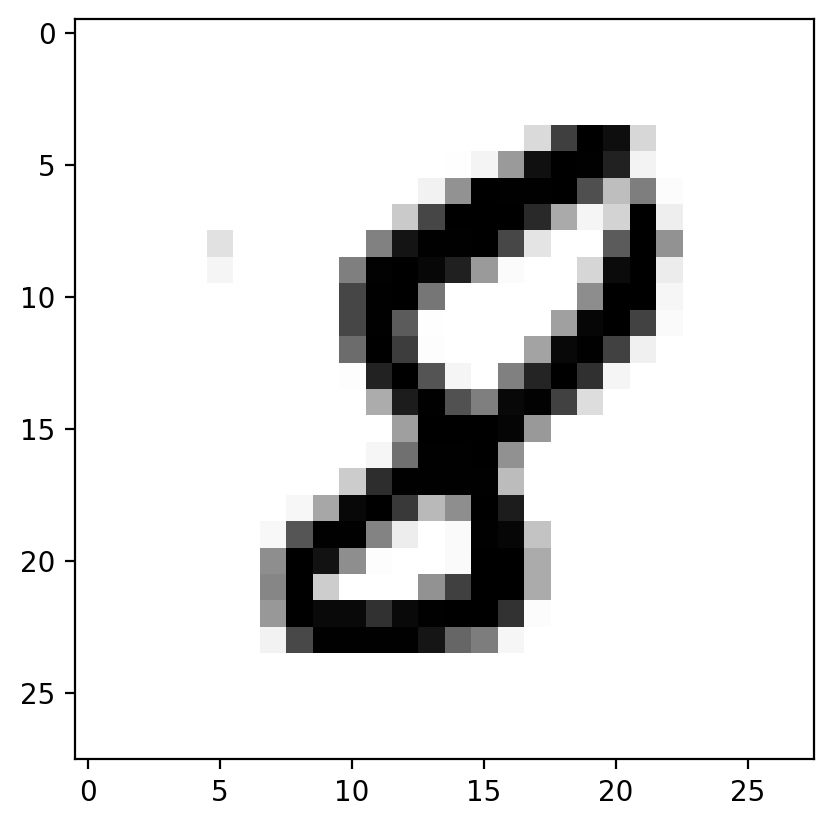

In [9]:
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r');


In [8]:
print(labels[1])

tensor(8)


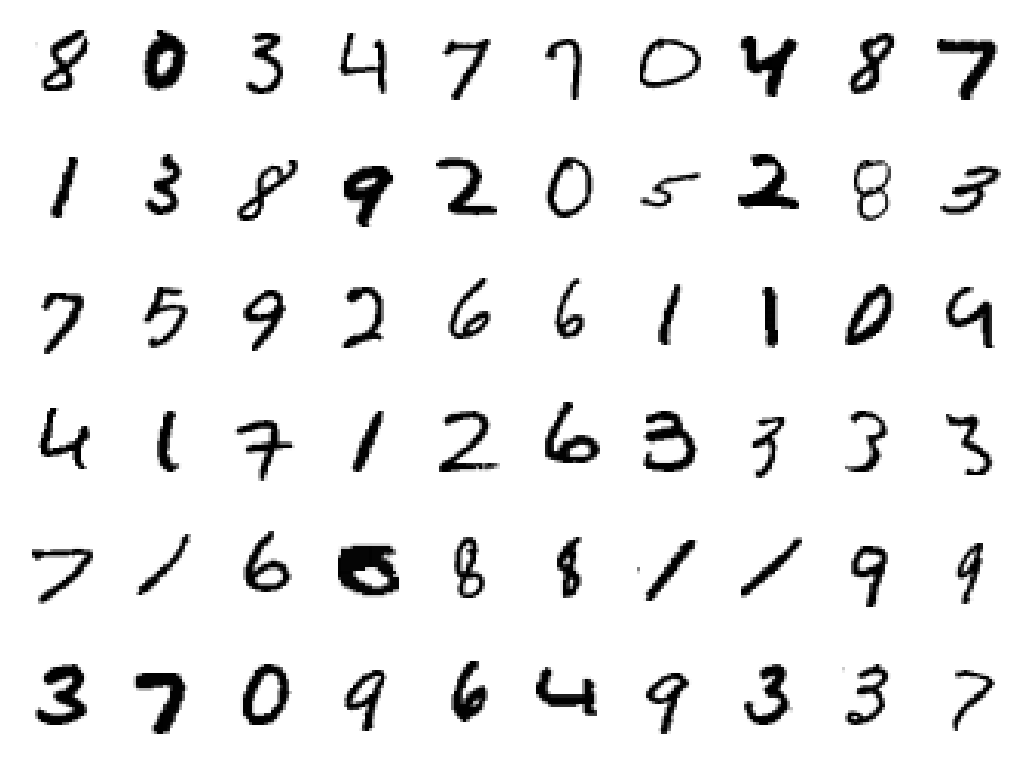

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining The Neural Network

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [11]:
from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [13]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images.cuda())
loss = criterion(logps, labels.cuda())

In [14]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 2.1274e-03,  2.1274e-03,  2.1274e-03,  ...,  2.1274e-03,
          2.1274e-03,  2.1274e-03],
        [ 1.4979e-03,  1.4979e-03,  1.4979e-03,  ...,  1.4979e-03,
          1.4979e-03,  1.4979e-03],
        [-3.8064e-04, -3.8064e-04, -3.8064e-04,  ..., -3.8064e-04,
         -3.8064e-04, -3.8064e-04],
        ...,
        [-3.3474e-05, -3.3474e-05, -3.3474e-05,  ..., -3.3474e-05,
         -3.3474e-05, -3.3474e-05],
        [ 1.2423e-03,  1.2423e-03,  1.2423e-03,  ...,  1.2423e-03,
          1.2423e-03,  1.2423e-03],
        [ 1.3429e-03,  1.3429e-03,  1.3429e-03,  ...,  1.3429e-03,
          1.3429e-03,  1.3429e-03]], device='cuda:0')


In [15]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images.cuda())
loss = criterion(output, labels.cuda())
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0114,  0.0183, -0.0115,  ..., -0.0267, -0.0321, -0.0175],
        [-0.0098,  0.0242, -0.0102,  ..., -0.0347,  0.0079, -0.0282],
        [-0.0196, -0.0178,  0.0274,  ...,  0.0317, -0.0261,  0.0053],
        ...,
        [-0.0065,  0.0330, -0.0105,  ..., -0.0171,  0.0187,  0.0168],
        [ 0.0201, -0.0256,  0.0337,  ..., -0.0301,  0.0309, -0.0120],
        [-0.0166, -0.0180,  0.0195,  ..., -0.0128, -0.0186, -0.0229]],
       device='cuda:0', requires_grad=True)
Gradient - tensor([[ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [ 0.0050,  0.0050,  0.0050,  ...,  0.0050,  0.0050,  0.0050]],
       device='cuda:0')


In [ ]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0114,  0.0183, -0.0115,  ..., -0.0267, -0.0321, -0.0175],
        [-0.0098,  0.0242, -0.0102,  ..., -0.0347,  0.0079, -0.0282],
        [-0.0196, -0.0178,  0.0274,  ...,  0.0317, -0.0261,  0.0053],
        ...,
        [-0.0065,  0.0330, -0.0105,  ..., -0.0171,  0.0187,  0.0168],
        [ 0.0201, -0.0256,  0.0338,  ..., -0.0301,  0.0309, -0.0120],
        [-0.0166, -0.0181,  0.0194,  ..., -0.0128, -0.0187, -0.0229]],
       device='cuda:0', requires_grad=True)


### Core Training Of Neural Network

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images.cuda())
        loss = criterion(output, labels.cuda())

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.6485169944621479
Epoch 1 - Training loss: 0.28772426600744727
Epoch 2 - Training loss: 0.22218721673321495
Epoch 3 - Training loss: 0.17751274647504917
Epoch 4 - Training loss: 0.14714437284306295
Epoch 5 - Training loss: 0.12703789881408722
Epoch 6 - Training loss: 0.11110581199465784
Epoch 7 - Training loss: 0.09855154845347283
Epoch 8 - Training loss: 0.08801297230649986
Epoch 9 - Training loss: 0.08139357314323947
Epoch 10 - Training loss: 0.07304080039945873
Epoch 11 - Training loss: 0.06733504345596854
Epoch 12 - Training loss: 0.061133228770610115
Epoch 13 - Training loss: 0.0577682187713222
Epoch 14 - Training loss: 0.0530630665571133

Training Time (in minutes) = 2.5549638867378235


In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 8


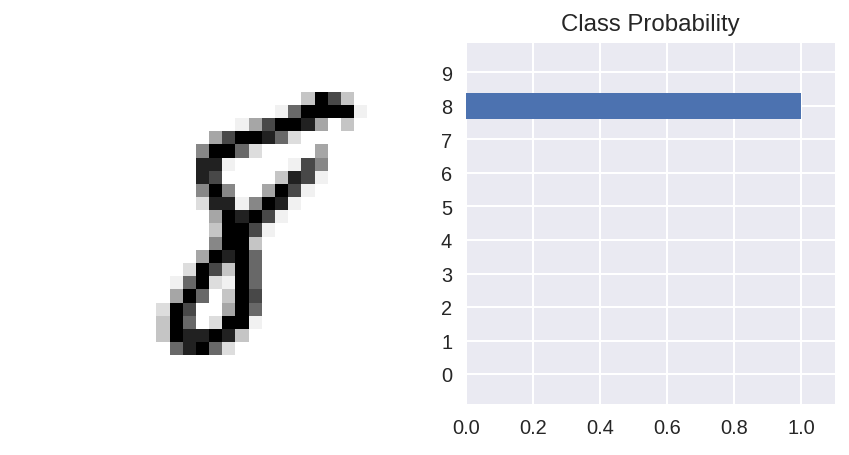

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### Model Evaluation

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9716
